# Collecting data from GooglePlay

This notebook is used to collect the dataset 'reviews.csv'. You are free to modify this code and customise the dataset according to your goals.

**Note:**

This code is designed to collect almost similar number of positive and negative reviews. However, it aims to show a way of data collection, may not be case of your analysis.

The function used for scraping app info and reviews is [google-play-scraper](https://github.com/JoMingyu/google-play-scraper).

## Setup

Let's install the required packages and setup the imports:

In [ ]:
# First time running this code, you need to install package 'google_play_scraper' 
!pip install --upgrade google_play_scraper

In [1]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app,reviews_all


Now let's create a list of Apps we want to collect.

We will need 'the Google Play ID', which is the unique identifier of an Android application. 
It can be found by searching for the app and finding the Play store web page for the app.

In the example below, the Google Play ID is ``com.amazon.mShop.android.shopping``, which you can find directly from its url address:

https://play.google.com/store/apps/details?id=com.amazon.mShop.android.shopping

You are free to define your own list of Apps.

In [2]:
# List of Apps and their packages to be collected. Here I choose some Apps under the category 'productivity'
app_packages = [
    'com.amazon.mShop.android.shopping',
    'com.zzkko',
    'com.asos.app',
    'com.alibaba.aliexpresshd',
    'com.ebay.mobile',
    'com.depop',
    'com.boots.flagship.android',
    'com.tesco.grocery.view',
    'com.homeretailgroup.argos.android',
    'com.morrisons.atm.mobile.android',
    'com.marksandspencer.app',
    'de.sec.mobile'
]

## Scraping App Information

Let's scrape the info for each app:

In [3]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(ap, lang='en', country='uk') # from the UK markert
    del info['comments']
    app_infos.append(info)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.27it/s]


Let's look at the corresponding JSON objects:

In [4]:
def print_json(json_object):
    json_str = json.dumps(
        json_object, 
        indent=2, 
        sort_keys=True, 
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [5]:
print_json(app_infos[0])

{
  "adSupported": true,
  "androidVersion": "8.0",
  "androidVersionText": "8.0 and up",
  "appId": "com.amazon.mShop.android.shopping",
  "containsAds": true,
  "contentRating": "Parental guidance",
  "contentRatingDescription": "Parental Guidance Recommended",
  "currency": "GBP",
  "description": "<h2><b>Product Features</b></h2>\r\nAmazon Shopping offers app-only benefits to help make shopping on Amazon faster and easier than shopping on your desktop.\r\n\r\n<h2><b>Never miss a delivery</b></h2>\r\nGet real-time tracking and delivery notifications so you know where your package is and when it arrives. \r\n\r\n<h2><b>Know exactly what you\u2019re purchasing</b></h2>\r\nFull 360\u00b0 product view lets you see items from every angle. \u201cView in you room\u201d makes sure it fits by using your phone\u2019s camera and VR so you can see it in your space. \r\n\r\n<h2><b>We\u2019ll notify you when items go on sale</b></h2>\r\nJust tap the heart icon to save items to Your Lists and we\u

## Print Logos

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). We can select what is relevant and even some of the info we like. For example, we can print all their logos. 

c:\users\果酱不加糖\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.


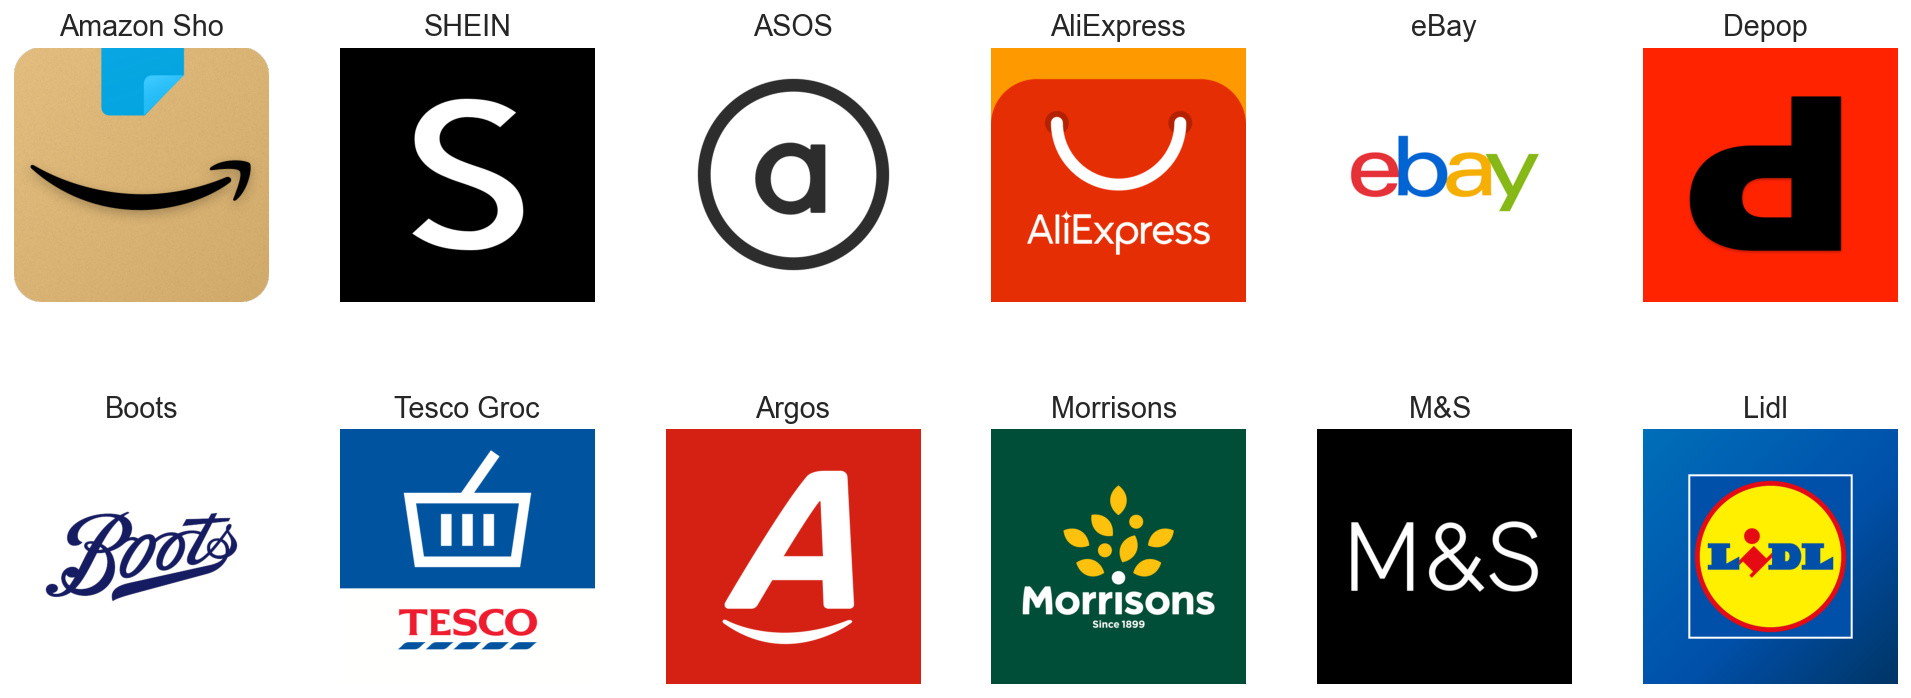

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Function to format and get the title
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

# Print logos and titles
fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')
    
fig.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0.5)

We'll store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [7]:
# App Data into Pandas DF and store it
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('./apps.csv', index=None, header=True)

## Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

See https://github.com/JoMingyu/google-play-scraper for configurations of function ``google_play_scraper.reviews``.

In [8]:
# This is an example of the function google_play_scraper.reviews
result, continuation_token = reviews(
    'com.fantome.penguinisle',
    lang='en', # defaults to 'en'
    country='uk', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
    count=3, # defaults to 100
    filter_score_with=5 # defaults to None(means all score)
)
result

[{'reviewId': 'gp:AOqpTOFvGjtpGGyAwvOgnZhok0-EdkRA9OeHVrQNkJKQlcjdQ2f1gVsOa_tzOCEUqAY8_EdkbCdwHwvK0QTBexI',
  'userName': 'Jim Bee',
  'userImage': 'https://play-lh.googleusercontent.com/a/AATXAJxZJvn7sjwDMnl6fiyDgx8eq6O53xYYr4gQiJzj=mo',
  'content': "Great game, very relaxing, and very fun. I discovered this game last year and I haven't spent a day without it. Very simple to learn. I love how updates happen every month with new and original penguins. Many great features, however my one complaint is that it takes an extraordinarily long time to reach different habitats unless you grind for a few hours every day. Other than that, it's great.",
  'score': 5,
  'thumbsUpCount': 47,
  'reviewCreatedVersion': '1.39.1',
  'at': datetime.datetime(2021, 10, 29, 10, 22, 34),
  'replyContent': None,
  'repliedAt': None},
 {'reviewId': 'gp:AOqpTOHm9KDAXHlxJvIbRq3y6Sp77nAVZZlakJdnFjuOGgwAC91mytD3TCwG3OV3jFkejHKhGqHoLWXqiLeTDdM',
  'userName': 'Isobel Latta',
  'userImage': 'https://play-lh.google

In [9]:
# result = reviews_all(
#     'com.fantome.penguinisle',
#     lang='en', # defaults to 'en'
#     country='uk', # defaults to 'us'
#     sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVAN
# )
# # result
# df_reviews=pd.DataFrame(np.array(result),columns=['review'])
# df_reviews=df_reviews.join(pd.DataFrame(df_reviews.pop('review').tolist()))

# df_reviews['score'].value_counts()

In [10]:
app_reviews = []

# Loop through all the app packages and collect review for each of them
for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                country='uk',
                sort=sort_order,
                count= 150 if score == 3 else 200,
                filter_score_with=score
            )
        for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap

        app_reviews.extend(rvs)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:59<00:00,  9.96s/it]


Note that we're adding the app id and sort order to each review. Here's an example for one:

In [ ]:
print_json(app_reviews[0])

`repliedAt` and `replyContent` contain the developer response to the review.

So, how many app reviews did we get?



In [11]:
print("We were able to scrap: ", len(app_reviews), " reviews")

We were able to scrap:  11112  reviews


Let's save the reviews to a CSV file:

In [12]:
# Save app reviews in a CSV format
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('./reviews.csv', index=None, header=True)

In [13]:
app_reviews_df['score'].value_counts()

1    2400
5    2400
2    2289
4    2287
3    1736
Name: score, dtype: int64